In [1]:
using Pkg

Pkg.activate("../neucgraph/")

  Activating project at `~/Projects/uhackathons/neucgraph/neucgraph`


In [2]:
#using Manifolds

In [3]:
using JSON
path = "../data/org_roam_records_2023_10_08.json"

"../data/org_roam_records_2023_10_08.json"

In [4]:
records = JSON.parse(read(path, String));

In [5]:
@kwdef struct OrgLink
    source_name :: String
    destination_name :: String
    source_date :: String
    destination_date :: String
end

function get_input_dict(struct_type, dict)
    fields = fieldnames(struct_type)
    Dict(
        [Symbol(k) => v for (k, v) in dict if Symbol(k) in fields]
    )
end

function dict_to_struct(struct_type, dict)
    mapped_dict = get_input_dict(struct_type, dict)
    struct_type(;mapped_dict...)
end

dict_to_struct (generic function with 1 method)

In [6]:
record = records[1];

In [7]:
record

Dict{String, Any} with 8 entries:
  "source_root_path"      => "roam"
  "destination_path"      => "roam/20230521224658-logic.org"
  "source_path"           => "roam/20230623112119-substructural_logic.org"
  "source_name"           => "substructural_logic.org"
  "destination_name"      => "logic.org"
  "destination_date"      => "20230521224658"
  "destination_root_path" => "roam"
  "source_date"           => "20230623112119"

In [8]:
dict_to_struct(OrgLink, record)

OrgLink("substructural_logic.org", "logic.org", "20230623112119", "20230521224658")

In [9]:
fields = fieldnames(OrgLink)
mapped_record = Dict(
    [Symbol(k) => v for (k, v) in record if Symbol(k) in fields]
)

Dict{Symbol, String} with 4 entries:
  :source_date      => "20230623112119"
  :destination_name => "logic.org"
  :source_name      => "substructural_logic.org"
  :destination_date => "20230521224658"

In [10]:
example_link = OrgLink(;mapped_record...)

OrgLink("substructural_logic.org", "logic.org", "20230623112119", "20230521224658")

In [11]:
links = [dict_to_struct(OrgLink, record) for record in records];

In [12]:
[(link.source_name, link.destination_name) for link in links]

705-element Vector{Tuple{String, String}}:
 ("substructural_logic.org", "logic.org")
 ("substructural_logic.org", "curry_howard.org")
 ("substructural_logic.org", "rust_types.org")
 ("substructural_logic.org", "c_algebras.org")
 ("renormalization.org", "math.org")
 ("ml_general.org", "general_nlp.org")
 ("ml_general.org", "ml_articles.org")
 ("metrics_mrr.org", "retrieval_nlp.org")
 ("llm_not_zero_shot_communicators.org", "chatgpt_implicature.org")
 ("mgr_lcsh.org", "mgr.org")
 ("readlog_logic.org", "logic.org")
 ("readlog_logic.org", "wittgenstein.org")
 ("readlog_logic.org", "logic_intensionality.org")
 ⋮
 ("lm_linguistics.org", "llms.org")
 ("lm_linguistics.org", "cogsci.org")
 ("lm_linguistics.org", "nlp_pragmatics.org")
 ("lm_linguistics.org", "cognitive_linguistics.org")
 ("llms_logic.org", "llms.org")
 ("papers_interesting.org", "ml_papers.org")
 ("lmclient.org", "lmserver.org")
 ("mgr_nbow_data.org", "mgr_function_signatures.org")
 ("pragmabench.org", "chatgpt_implicature.org")

In [13]:
using LightGraphs # graph library
using SimpleWeightedGraphs



struct LabeledGraph
    graph
    node_to_index :: Dict{String, Int64}    
end

function get_sorted_vertices(labeled_graph)
    [name for (name, _) in sort(collect(labeled_graph.node_to_index), by=x -> x[2])]
end
    
function make_graph(edges)
    # Get unique nodes to determine # of vertices
    nodes = unique(v for e in edges for v in e)

    # Create a mapping from node names to indices
    node_to_index = Dict(node => index for (index, node) in enumerate(nodes))
    
    num_vertices = length(nodes)

    # Create an unweighted simple graph
    G = SimpleGraph(num_vertices)

    # Add edges to the graph
    for edge in edges
        add_edge!(G, node_to_index[edge[1]], node_to_index[edge[2]])
    end

    # Compute pairwise shortest path lengths
    #dist_matrix = floyd_warshall_shortest_paths(G).dists
    LabeledGraph(G, node_to_index)
end

function get_distance_matrix(labeled_graph :: LabeledGraph) 
    floyd_warshall_shortest_paths(labeled_graph.graph).dists
end


function filter_small_connected_components(labeled_graph, min_component_size)
    valid_vertices :: Vector{Int64} = []
    for cc in weakly_connected_components(labeled_graph.graph) 
        if length(cc) > min_component_size
            valid_vertices = [valid_vertices; cc]
        end
    end
    filtered_graph, _ = induced_subgraph(labeled_graph.graph, valid_vertices)
    node_to_index = Dict(node => index for (node, index) in labeled_graph.node_to_index if index in valid_vertices)
    LabeledGraph(filtered_graph, node_to_index)
end

link_edges = [(link.source_name, link.destination_name) for link in links]

raw_labeled_graph = make_graph(link_edges)

LabeledGraph({548, 677} undirected simple Int64 graph, Dict("optaplanner.org" => 118, "org_ai_project.org" => 540, "org_ai_elixir.org" => 375, "readlog_cogsci.org" => 344, "python_code_ast.org" => 147, "cognitive_linguistics.org" => 113, "chatgpt_conversations_lean.org" => 101, "readlog.org" => 343, "mgr_nbow.org" => 387, "summarization.org" => 223…))

In [14]:
labeled_graph = filter_small_connected_components(raw_labeled_graph, 10)

LabeledGraph({511, 654} undirected simple Int64 graph, Dict("org_ai_project.org" => 540, "org_ai_elixir.org" => 375, "readlog_cogsci.org" => 344, "cognitive_linguistics.org" => 113, "chatgpt_conversations_lean.org" => 101, "readlog.org" => 343, "mgr_nbow.org" => 387, "summarization.org" => 223, "curry_howard.org" => 3, "llama_index.org" => 152…))

In [15]:
labeled_graph

LabeledGraph({511, 654} undirected simple Int64 graph, Dict("org_ai_project.org" => 540, "org_ai_elixir.org" => 375, "readlog_cogsci.org" => 344, "cognitive_linguistics.org" => 113, "chatgpt_conversations_lean.org" => 101, "readlog.org" => 343, "mgr_nbow.org" => 387, "summarization.org" => 223, "curry_howard.org" => 3, "llama_index.org" => 152…))

In [16]:
dists = (labeled_graph |> get_distance_matrix)

511×511 Matrix{Int64}:
  0   1   1  1   1   5   4   4   5   5  …   7  4  5  6  6  10   6   6  5   9
  1   0   2  2   2   4   3   5   4   6      8  5  6  7  7  11   5   7  6   9
  1   2   0  2   2   4   3   3   4   4      6  5  6  7  7  11   5   5  6   8
  1   2   2  0   2   6   5   5   5   6      7  3  4  5  5   9   6   6  4   8
  1   2   2  2   0   6   5   5   6   6      8  5  6  7  7  11   7   7  6  10
  5   4   4  6   6   0   1   4   5   5  …   7  8  5  6  6  13   6   6  8   9
  4   3   3  5   5   1   0   3   4   4      6  7  4  5  5  12   5   5  7   8
  4   5   3  5   5   4   3   0   1   1      3  5  3  4  4  10   2   2  4   5
  5   4   4  5   6   5   4   1   0   2      4  4  3  4  4  10   3   3  5   5
  5   6   4  6   6   5   4   1   2   0      4  6  4  5  5  11   3   3  5   6
  7   6   6  6   8   6   5   3   2   4  …   5  5  2  3  3  10   4   4  6   6
  6   5   5  6   7   6   5   2   1   3      5  5  3  4  4  11   4   4  6   6
  8   7   7  7   9   8   7   4   5   5      5  6  5  

## Now the hyperbolic stuff

https://browse.arxiv.org/pdf/1804.03329.pdf

In [17]:
dists

511×511 Matrix{Int64}:
  0   1   1  1   1   5   4   4   5   5  …   7  4  5  6  6  10   6   6  5   9
  1   0   2  2   2   4   3   5   4   6      8  5  6  7  7  11   5   7  6   9
  1   2   0  2   2   4   3   3   4   4      6  5  6  7  7  11   5   5  6   8
  1   2   2  0   2   6   5   5   5   6      7  3  4  5  5   9   6   6  4   8
  1   2   2  2   0   6   5   5   6   6      8  5  6  7  7  11   7   7  6  10
  5   4   4  6   6   0   1   4   5   5  …   7  8  5  6  6  13   6   6  8   9
  4   3   3  5   5   1   0   3   4   4      6  7  4  5  5  12   5   5  7   8
  4   5   3  5   5   4   3   0   1   1      3  5  3  4  4  10   2   2  4   5
  5   4   4  5   6   5   4   1   0   2      4  4  3  4  4  10   3   3  5   5
  5   6   4  6   6   5   4   1   2   0      4  6  4  5  5  11   3   3  5   6
  7   6   6  6   8   6   5   3   2   4  …   5  5  2  3  3  10   4   4  6   6
  6   5   5  6   7   6   5   2   1   3      5  5  3  4  4  11   4   4  6   6
  8   7   7  7   9   8   7   4   5   5      5  6  5  

In [18]:
D = dists ./ maximum(dists);
# Recovery via matrix factorization
DH = cosh.(D); 

In [19]:
D

511×511 Matrix{Float64}:
 0.0        0.0526316  0.0526316  0.0526316  …  0.315789  0.263158  0.473684
 0.0526316  0.0        0.105263   0.105263      0.368421  0.315789  0.473684
 0.0526316  0.105263   0.0        0.105263      0.263158  0.315789  0.421053
 0.0526316  0.105263   0.105263   0.0           0.315789  0.210526  0.421053
 0.0526316  0.105263   0.105263   0.105263      0.368421  0.315789  0.526316
 0.263158   0.210526   0.210526   0.315789   …  0.315789  0.421053  0.473684
 0.210526   0.157895   0.157895   0.263158      0.263158  0.368421  0.421053
 0.210526   0.263158   0.157895   0.263158      0.105263  0.210526  0.263158
 0.263158   0.210526   0.210526   0.263158      0.157895  0.263158  0.263158
 0.263158   0.315789   0.210526   0.315789      0.157895  0.263158  0.315789
 0.368421   0.315789   0.315789   0.315789   …  0.210526  0.315789  0.315789
 0.315789   0.263158   0.263158   0.315789      0.210526  0.315789  0.315789
 0.421053   0.368421   0.368421   0.368421      0.2

In [20]:
using  MultivariateStats 

In [21]:
hpca = fit(PCA, -DH, maxoutdim=3)

PCA(indim = 511, outdim = 3, principalratio = 0.8707270471615592)

Pattern matrix (unstandardized loadings):
──────────────────────────────────────────
           PC1           PC2           PC3
──────────────────────────────────────────
1    0.0191744  -0.0100829     0.0239424
2    0.0201778  -0.0180669     0.0285281
3    0.0232931  -0.0211316     0.0177634
4    0.0195702   0.00455242    0.0222018
5    0.0212382  -0.011698      0.0280691
6    0.02535    -0.0243532     0.0140525
7    0.0225186  -0.0206627     0.0118413
8    0.0213191  -0.0125831    -0.00241591
9    0.023743   -0.00950204    0.000664293
10   0.0253691  -0.0150921    -0.00319094
11   0.0250874   0.00292564    0.000858006
12   0.0259366  -0.00758595    4.22273e-5
13   0.0318806  -0.00384506   -0.00171018
14   0.0287617  -0.00447945   -0.00418797
15   0.0306022   0.015516     -0.000914086
16   0.0264249   0.0130081    -0.00067417
17   0.02567    -0.0185564     0.0163397
18   0.0287645  -0.0213799     0.0189917
19   0.02854

In [22]:
X_lorentz = hpca.proj

511×3 Matrix{Float64}:
 0.0295327  -0.0254202    0.100649
 0.0310781  -0.0455488    0.119926
 0.0358764  -0.053275     0.0746739
 0.0301424   0.0114771    0.0933317
 0.0327114  -0.0294919    0.117997
 0.0390445  -0.0613971    0.0590738
 0.0346835  -0.0520928    0.0497784
 0.0328361  -0.0317235   -0.010156
 0.0365693  -0.0239557    0.00279255
 0.0390739  -0.0380488   -0.0134141
 0.0386401   0.00737586   0.00360688
 0.039948   -0.019125     0.000177515
 0.049103   -0.00969383  -0.00718923
 ⋮                       
 0.0390445  -0.0613971    0.0590738
 0.0430425  -0.0283293    0.00215702
 0.0455524  -0.00812355  -0.0242084
 0.0358749   0.0457989    0.0705754
 0.0284982   0.022789    -0.000871316
 0.034659    0.0285129   -0.00137028
 0.034659    0.0285129   -0.00137028
 0.0578794   0.11711      0.13143
 0.0376784  -0.00966647  -0.0162687
 0.0393707  -0.00547307  -0.0231372
 0.0443098   0.0192188    0.0331199
 0.0549163   0.0222493   -0.028805

In [23]:
using DataFrames
using PyPlot

In [24]:
using LinearAlgebra

In [25]:
X = X_lorentz[:, 2:3] ./ (1 .+ X_lorentz[:,1])

511×2 Matrix{Float64}:
 -0.024691     0.0977618
 -0.0441759    0.116312
 -0.0514299    0.0720876
  0.0111413    0.0906008
 -0.0285578    0.114259
 -0.0590899    0.0568539
 -0.0503466    0.0481098
 -0.0307149   -0.0098331
 -0.0231106    0.00269403
 -0.036618    -0.0129096
  0.00710146   0.0034727
 -0.0183904    0.000170696
 -0.00924012  -0.00685274
  ⋮           
 -0.0590899    0.0568539
 -0.0271602    0.00206801
 -0.00776962  -0.0231537
  0.0442127    0.0681312
  0.0221575   -0.000847173
  0.0275578   -0.00132438
  0.0275578   -0.00132438
  0.110703     0.124239
 -0.00931547  -0.015678
 -0.00526576  -0.0222608
  0.0184033    0.0317147
  0.021091    -0.0273055

In [33]:
using InMemoryDatasets

In [38]:
ds_poincare = Dataset(x=X[:,1], y=X[:,2], name=get_sorted_vertices(labeled_graph));


In [30]:
using StatisticalGraphics

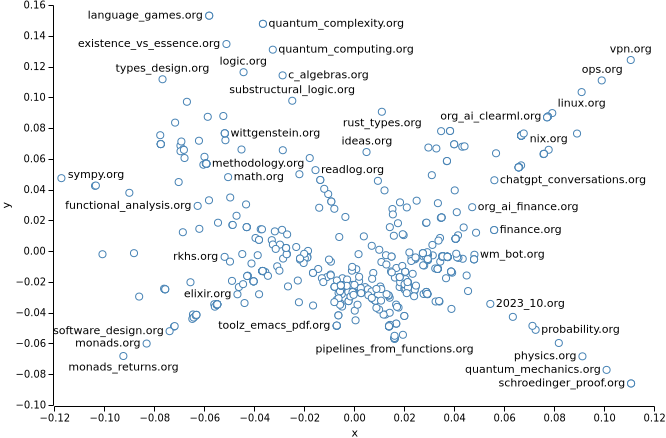

In [40]:
sgplot(ds_poincare, Scatter(x=:x,y=:y,labelresponse=:name))